In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from skimage.color import rgb2gray, rgba2rgb
from skimage.transform import iradon, radon
import json
from json import JSONEncoder
from pathlib import Path

class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

%config InlineBackend.print_figure_kwargs = {'pad_inches':0} # NOT

def show(img, cmap="gray"):
    plt.imshow(img, cmap)
    plt.axis("off")

In [2]:
image_data = Image.open("ct_legs_scanner_360.png")
image_data = np.array(image_data.convert("RGBA"))
image = rgb2gray(1 - rgba2rgb(image_data))
image.min(), image.max()

(0.0, 1.0)

# Continuous

(-0.5, 359.5, 359.5, -0.5)

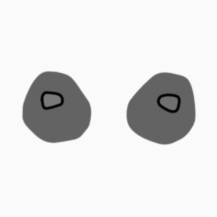

In [3]:
theta = np.linspace(0.0 + 90, 180.0 + 90, max(image.shape), endpoint=False)
sinogram = radon(image, theta=theta)
plt.imshow(-iradon(sinogram, theta=theta, filter_name="shepp-logan"), cmap="gray")
plt.axis("off")

(-0.5, 359.5, 359.5, -0.5)

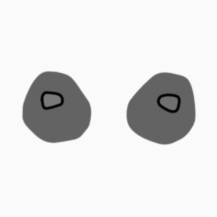

In [4]:
imgs = []
for i in range(0, 20):
    fromangle = 18 * i
    toangle = 18 * i + 18
    thetaX = theta[fromangle:toangle]
    sinogramX = sinogram[:, fromangle:toangle]
    filtered_imX = iradon(sinogramX, theta=thetaX, filter_name="shepp-logan")
    imgs.append(-filtered_imX)


img_final = imgs[0] * 0

for im in imgs:
    img_final += im

plt.imshow(img_final, cmap="gray")
#plt.imshow(np.clip((img_final) / 20, -1, 0), cmap="gray")
plt.axis("off")

In [5]:
# prepare json

json_datastack = []
for d in imgs:
    data = np.around(d, decimals=2)
    json_datastack.append(data)

keys = []
for i in range(0, len(imgs)):
    keys.append(f"img_{i+1:0>3}")

json_content_compressed = dict(zip(keys, json_datastack))

# save json


with Path("legs_continuous.json").open("w") as jsonFile:
    json.dump(
        json_content_compressed,
        jsonFile,
        indent=0,
        sort_keys=False,
        cls=NumpyArrayEncoder,
    )

## Discrete

(-0.5, 359.5, 359.5, -0.5)

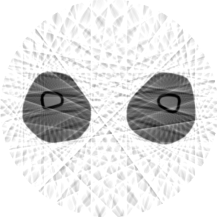

In [11]:
imgs = []
for i in range(0, 20):
    fromangle = 18 * i
    toangle = 18 * i + 1
    thetaX = theta[fromangle:toangle]
    sinogramX = sinogram[:, fromangle:toangle]
    filtered_imX = iradon(sinogramX, theta=thetaX, filter_name="shepp-logan")
    imgs.append(-filtered_imX)


img_final = imgs[0] * 0

for im in imgs:
    img_final += im

#plt.imshow(img_final, cmap="gray")
plt.imshow(np.clip((img_final) / 20, -1, 0), cmap="gray")
plt.axis("off")

In [13]:
# prepare json

json_datastack = []
for d in imgs:
    data = np.around(d, decimals=2)
    json_datastack.append(data)

keys = []
for i in range(0, len(imgs)):
    keys.append(f"img_{i+1:0>3}")

json_content_compressed = dict(zip(keys, json_datastack))

# save json


with Path("legs_discrete.json").open("w") as jsonFile:
    json.dump(
        json_content_compressed,
        jsonFile,
        indent=0,
        sort_keys=False,
        cls=NumpyArrayEncoder,
    )